In [6]:
import os 
import numpy as np

# Compute FSC again 
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps 
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map 
from locscale.include.emmer.pdb.pdb_to_map import pdb2map 
refmac_iterations = np.arange(1, 50)

output_folder_with_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/refinement/processing_files"
model_map_save_loc_with_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/refinement/model_maps_refmac_50_iterations"
refined_modelmap_per_iteration_without_averaging = {k : os.path.join(output_folder_with_averaging,f"shifted_servalcat_refinement_cycle_{k}_servalcat_refined.mmcif") for k in refmac_iterations}

input_folder = os.path.dirname(output_folder_with_averaging)
halfmap1_path = os.path.join(input_folder, "emd_8702_half_map_1.map")
halfmap2_path = os.path.join(input_folder, "emd_8702_half_map_2.map")

emmap, apix = load_map(halfmap1_path)
plot_data_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/plot_data_8702"
if not os.path.exists(plot_data_folder):
    os.makedirs(plot_data_folder)

def compute_fsc_cycle(cycle, halfmap1_path, halfmap2_path,refined_model_map_path):
    #refined_model_cycle = refined_modelmap_per_iteration[cycle]

    assert os.path.exists(refined_model_map_path), f"Refined model map path {refined_model_map_path} does not exist"
    assert os.path.exists(halfmap1_path), f"Halfmap1 path {halfmap1_path} does not exist"
    assert os.path.exists(halfmap2_path), f"Halfmap2 path {halfmap2_path} does not exist"
    
    fsc_vals_halfmap1 = calculate_fsc_maps(refined_model_map_path, halfmap1_path)
    fsc_vals_halfmap2 = calculate_fsc_maps(refined_model_map_path, halfmap2_path)

    fsc_average_halfmap1 = (cycle, np.mean(fsc_vals_halfmap1), fsc_vals_halfmap1)
    fsc_average_halfmap2 = (cycle, np.mean(fsc_vals_halfmap2), fsc_vals_halfmap2)

    results = { 
        "cycle" : cycle,
        "halfmap1" : fsc_average_halfmap1,
        "halfmap2" : fsc_average_halfmap2
    }
    return results

def create_model_map_path(cycle):
    pdb_path = refined_modelmap_per_iteration_without_averaging[cycle]
    simmap = pdb2map(pdb_path, size=emmap.shape, apix=apix)
    save_as_mrc(simmap, os.path.join(model_map_save_loc_with_averaging, f"model_map_cycle_{cycle}.mrc"), apix=apix)
    


In [ ]:
import joblib
# Run the computation in parallel for all the cycles (for the case: without averaging)
n_jobs = 15
verbose = 10

# Create the model map for each cycle
joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(
    joblib.delayed(create_model_map_path)(cycle) for cycle in refmac_iterations
)


In [8]:

# Run the computation in parallel for all the cycles (for the case: with averaging)
refmac_iterations = np.arange(1, 50)
model_map_paths_with_averaging = {k : os.path.join(model_map_save_loc_with_averaging, f"model_map_cycle_{k}.mrc") for k in refmac_iterations}
results_with_averaging = joblib.Parallel(n_jobs=n_jobs, verbose=10)(joblib.delayed(compute_fsc_cycle)(cycle, halfmap1_path, halfmap2_path, model_map_paths_with_averaging[cycle])\
                                                        for cycle in refmac_iterations)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  3.5min
[Parallel(n_jobs=15)]: Done  25 out of  49 | elapsed:  3.6min remaining:  3.5min
[Parallel(n_jobs=15)]: Done  30 out of  49 | elapsed:  3.6min remaining:  2.3min
[Parallel(n_jobs=15)]: Done  35 out of  49 | elapsed:  5.2min remaining:  2.1min
[Parallel(n_jobs=15)]: Done  40 out of  49 | elapsed:  5.3min remaining:  1.2min
[Parallel(n_jobs=15)]: Done  45 out of  49 | elapsed:  5.4min remaining:   28.5s
[Parallel(n_jobs=15)]: Done  49 out of  49 | elapsed:  6.6min finished


In [9]:
# dump the results into a pickle file
import pickle 
pickle_path = os.path.join(plot_data_folder, "fsc_results_with_averaging.pkl")
with open(pickle_path, "wb") as f:
    pickle.dump(results_with_averaging, f)

In [10]:
fsc_cycles_halfmap1_with_averaging = {}
fsc_cycles_halfmap2_with_averaging = {}
for result in results_with_averaging:
    cycle = result["cycle"]
    fsc_cycles_halfmap1_with_averaging[cycle] = result["halfmap1"]
    fsc_cycles_halfmap2_with_averaging[cycle] = result["halfmap2"]




In [11]:
def jsonify_dictionary(input_dict):
    # convert pickle object to json object
    new_dict = {}
    for key, value in input_dict.items():
        key = str(key) 
        value_is_iterable = isinstance(value, (list, tuple, np.ndarray))
        value_is_dict = isinstance(value, dict)
        value_is_float = isinstance(value, float)
        value_is_int = isinstance(value, (np.int64, int, np.int32))
        value_is_string = isinstance(value, str)
        
        print("key: {}, value_is_iterable: {}, value_is_dict: {}, value_is_float: {}, \
              value_is_int: {}, value_is_string: {}".format(key, value_is_iterable, \
                                                            value_is_dict, value_is_float, value_is_int, value_is_string))
        
        if value_is_dict:
            new_value = jsonify_dictionary(value)
        elif value_is_iterable:
            new_value = [str(x) for x in value]
        elif not value_is_string:
            new_value = str(value)
        
        new_dict[key] = new_value
        
    
    return new_dict 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


key: fsc_cycles_halfmap1_with_averaging, value_is_iterable: False, value_is_dict: True, value_is_float: False,               value_is_int: False, value_is_string: False
key: 1, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 2, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 3, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 4, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 5, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 6, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 7, value_i

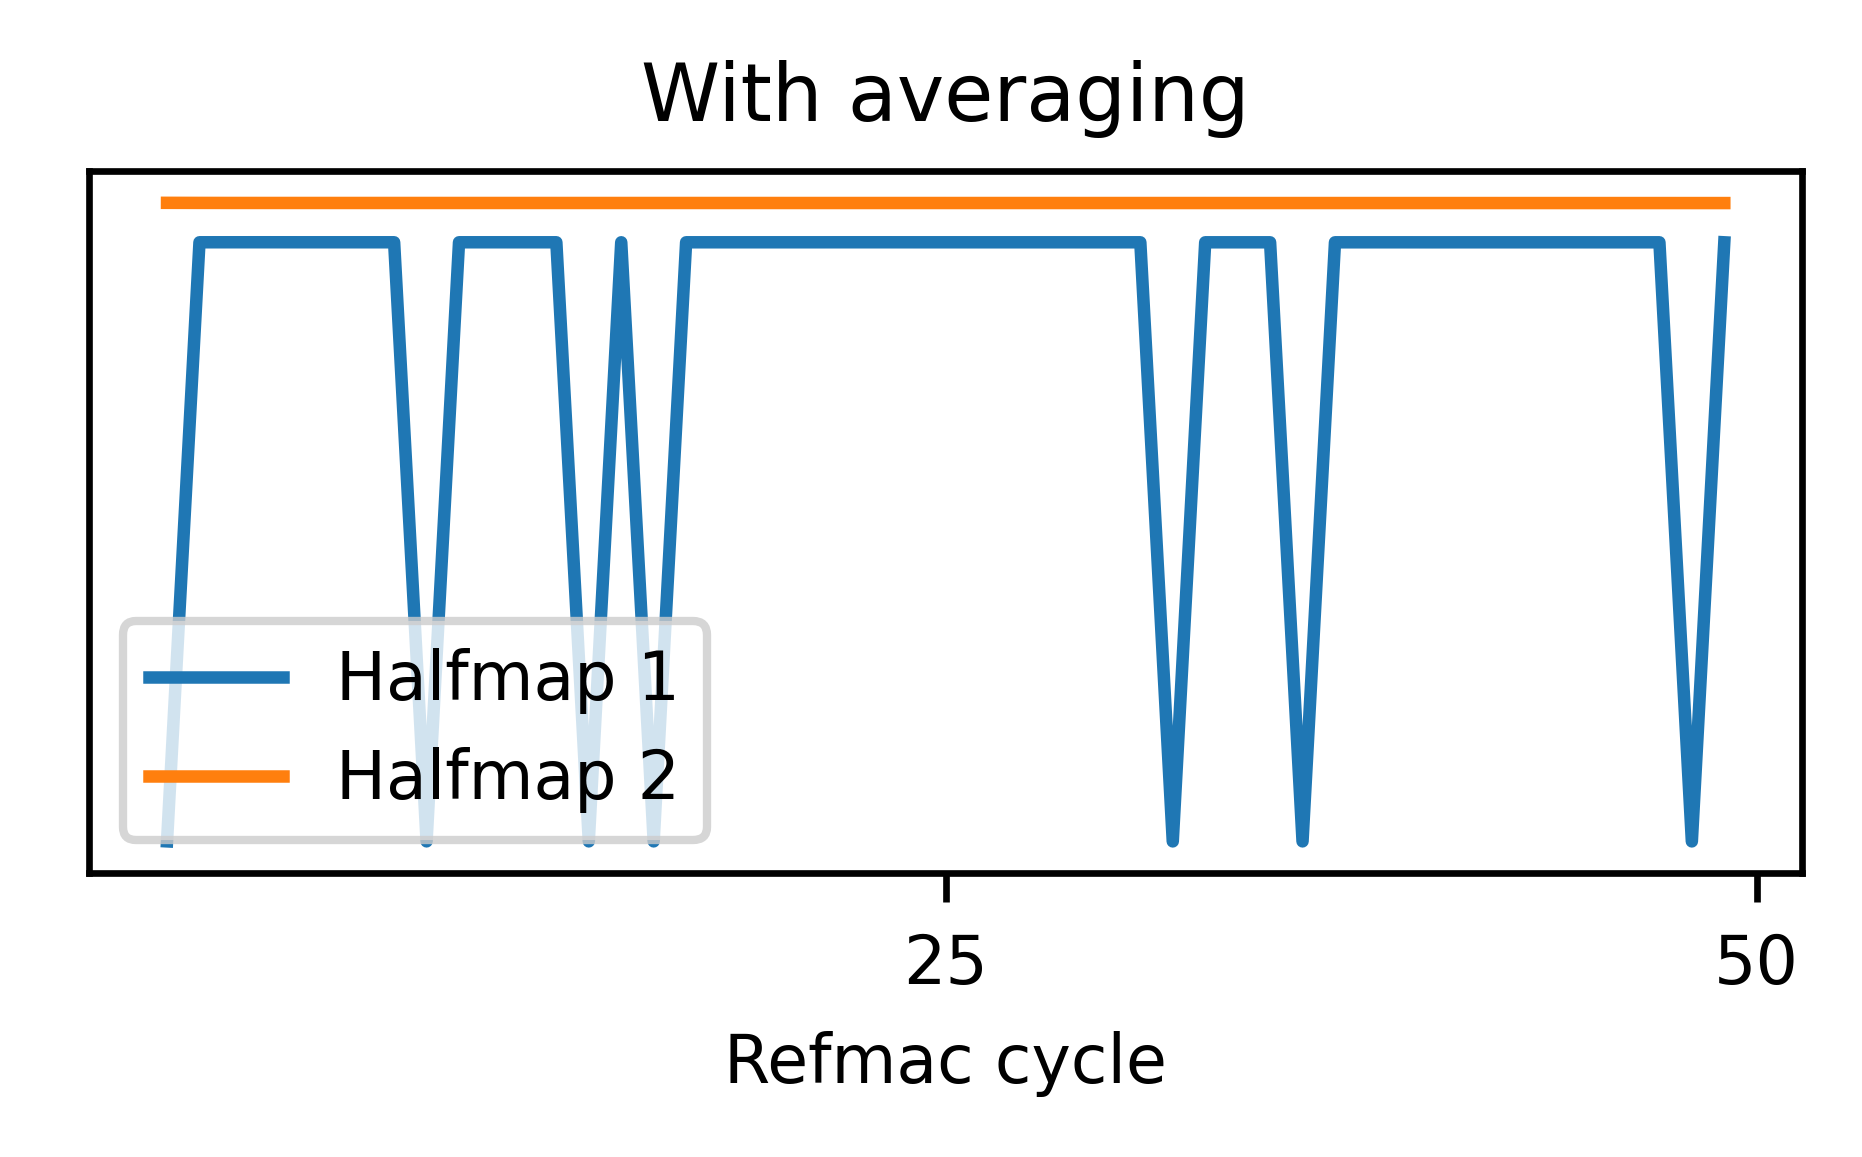

In [15]:
fsc_average_curve_halfmap1_with_averaging = [fsc_cycles_halfmap1_with_averaging[cycle][1] for cycle in refmac_iterations]
fsc_average_curve_halfmap2_with_averaging = [fsc_cycles_halfmap2_with_averaging[cycle][1] for cycle in refmac_iterations]

import matplotlib.pyplot as plt
figsize_cm = (8,5)
figsize_inch = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
fig, ax = plt.subplots(1, 1, figsize=figsize_inch, dpi=600)
# set font size to font
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
yticks = [0.5, 0.6]
xticks = [25, 50]

ax.plot(refmac_iterations, fsc_average_curve_halfmap1_with_averaging, label="Halfmap 1")
ax.plot(refmac_iterations, fsc_average_curve_halfmap2_with_averaging, label="Halfmap 2")
ax.set_xlabel("Refmac cycle")
ax.set_ylabel("FSC")
ax.set_title("With averaging")
#ax.set_ylim([0.45, 0.6])
# hide y axis
ax.get_yaxis().set_visible(False)
ax.set_xticks(xticks, fontsize=fontsize)
ax.legend()

plt.tight_layout()

plt.savefig(os.path.join(plot_data_folder, "fsc_curves_with_averaging.eps"), bbox_inches='tight')

# dump the results into a json file 
import json
results = {
    "fsc_cycles_halfmap1_with_averaging" : fsc_cycles_halfmap1_with_averaging,
    "fsc_cycles_halfmap2_with_averaging" : fsc_cycles_halfmap2_with_averaging,
    "cycles" : refmac_iterations,
}

with open(os.path.join(plot_data_folder, "fsc_curves_with_and_without_averaging.json"), "w") as f:
    json.dump(jsonify_dictionary(results), f, indent=4)

In [13]:
def crop_map(vol):
    center_z = 150
    center_y = 200
    center_x = 200
    center = (center_z,center_y,center_x)
    width = 150
    height = width
    depth = width
    start_index_z = center_z - depth//2
    end_index_z = center_z + depth//2
    start_index_y = center_y - height//2
    end_index_y = center_y + height//2
    start_index_x = center_x - width//2
    end_index_x = center_x + width//2
    cropped_vol = vol[start_index_z:end_index_z,start_index_y:end_index_y,start_index_x:end_index_x]
    return cropped_vol

def compute_fsc_cycle_cropped(cycle, halfmap1_path, halfmap2_path,refined_model_map_path):
    #refined_model_cycle = refined_modelmap_per_iteration[cycle]

    assert os.path.exists(refined_model_map_path), f"Refined model map path {refined_model_map_path} does not exist"
    assert os.path.exists(halfmap1_path), f"Halfmap1 path {halfmap1_path} does not exist"
    assert os.path.exists(halfmap2_path), f"Halfmap2 path {halfmap2_path} does not exist"
    
    model_map, apix = load_map(refined_model_map_path)
    halfmap1, apix = load_map(halfmap1_path)
    halfmap2, apix = load_map(halfmap2_path)
    
    cropped_model_map = crop_map(model_map)
    cropped_halfmap1 = crop_map(halfmap1)
    cropped_halfmap2 = crop_map(halfmap2)
    
    fsc_vals_halfmap1 = calculate_fsc_maps(cropped_model_map, cropped_halfmap1)
    fsc_vals_halfmap2 = calculate_fsc_maps(cropped_model_map, cropped_halfmap2)

    fsc_average_halfmap1 = (cycle, np.mean(fsc_vals_halfmap1), fsc_vals_halfmap1)
    fsc_average_halfmap2 = (cycle, np.mean(fsc_vals_halfmap2), fsc_vals_halfmap2)

    results = { 
        "cycle" : cycle,
        "cropped_halfmap1" : fsc_average_halfmap1,
        "cropped_halfmap2" : fsc_average_halfmap2
    }
    return results

In [ ]:

# Run the computation in parallel for all the cycles (for the case: with averaging)
refmac_iterations = np.arange(1, 50)
model_map_paths_with_averaging = {k : os.path.join(model_map_save_loc_with_averaging, f"model_map_cycle_{k}.mrc") for k in refmac_iterations}
results_with_averaging_cropped = joblib.Parallel(n_jobs=n_jobs, verbose=10)(joblib.delayed(compute_fsc_cycle)(cycle, halfmap1_path, halfmap2_path, model_map_paths_with_averaging[cycle])\
                                                        for cycle in refmac_iterations)


